In [3]:
import numpy as np
import qiskit as q # version 1.1
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, transpile
from qiskit.circuit.library import Diagonal
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt
import qiskit.circuit.library as qlib
from qiskit_aer import AerSimulator # version 0.15

# %matplotlib inline

print(f'Qiskit: {q.__version__}')
print(f'Numpy: {np.__version__}')

Qiskit: 1.1.2
Numpy: 2.1.1


In [4]:
#both parameters

M = 16 # lattices

dim = 2
dirs = 5

nlat = int(np.ceil(np.log2(M)))
nlinks = int(np.ceil(np.log2(dirs)))

In [5]:
backend = AerSimulator()

In [6]:
vorticity = np.zeros((M,M))
streamfunction = np.zeros((M,M))

w = (2/6,1/6,1/6,1/6,1/6)
e = (0,-1,1,1,-1) 
cs = np.sqrt(3)   ##speed of sound 
U = 1
lambdas = [np.arccos(i) for i in w]#streamfunction lambdas, can use adv-dif

In [7]:
# for boundaries
def top_half(A):
    def convert(val):
        return val+1j*np.sqrt(1-val**2)
    func = np.vectorize(convert)
    return func(A)
def bottom_half(A):
    def convert(val):
        return val-1j*np.sqrt(1-val**2)
    func = np.vectorize(convert)
    return func(A)

In [8]:
#for collision gates
def createLambda(oper, isC1 = True):
    ctrl = oper
    if oper >= 8:
        oper -= 8
    s = bin(ctrl)[2:]
    s = '0'*int((4-len(s))) + s
    nlambda = lambdas[oper]
    
    if not isC1:
        nlambda*=-1

    qc = QuantumCircuit(2+nlinks)
    tmp = QuantumCircuit(1)

    tmp.p(nlambda, 0)
    tmp.x(0)
    tmp.p(nlambda, 0)
    tmp.x(0)
    
    gate = tmp.to_gate(label = "Lambda"+str(ctrl)).control(nlinks+1,ctrl_state = s)
    
    cbits = [i for i in range(1,nlinks+2)]
    cbits.append(0)
    qc.append(gate,cbits)
    return qc

In [9]:
#prop gates
def rshift(n):
    circ = QuantumCircuit(n)
    for i in range(n):
        if i == n-1:
            circ.x(i)
        else:
            circ.mcx(list(range(i+1,n)), i)
    return circ

def lshift(n):
    circ = QuantumCircuit(n)
    for i in reversed(range(n)):
        if i == n-1:
            circ.x(i)
        else:
            circ.mcx(list(range(i+1,n)), i)
    return circ

In [10]:
def streamCirc():
    q = QuantumRegister(nlinks+dim*nlat+1,'q')
    a = AncillaRegister(1,'a')

    setup = QuantumCircuit(q)
    setup.add_register(a)

    h1 = qlib.HGate().control(1,ctrl_state = 0)

    cb = [a,0]
    cb.extend([i for i in range(dim*nlat, dim*nlat+nlinks+1)])
    setup.h(a)
    for i in range(dirs):
        setup.append(createLambda(i,True).to_gate(label = 'Lambda'+str(i)).control(1,ctrl_state = 0),cb)
    for i in range(8,13):
        setup.append(createLambda(i,True).to_gate(label = 'Lambda'+str(i)).control(1,ctrl_state = 0),cb)
    for i in range(dirs):
        setup.append(createLambda(i,False).to_gate(label = 'Lambda'+str(i)).control(1,ctrl_state = 1),cb)
    for i in range(8,13):
        setup.append(createLambda(i,False).to_gate(label = 'Lambda'+str(i)).control(1,ctrl_state = 1),cb)
    setup.h(q[11])
    setup.h(a)
    
    setup.barrier()
    L1 = lshift(nlat).to_gate(label = "L").control(nlinks+1,ctrl_state = '0001')
    R1 = rshift(nlat).to_gate(label = "R").control(nlinks+1,ctrl_state = '0010')
    L2 = lshift(nlat).to_gate(label = "L").control(nlinks+1,ctrl_state = '0011')
    R2 = rshift(nlat).to_gate(label = "R").control(nlinks+1,ctrl_state = '0100')
    setup.append(L1,[8,9,10,a[0],3,2,1,0])
    setup.append(R1,[8,9,10,a[0],3,2,1,0])
    setup.append(L2,[8,9,10,a[0],7,6,5,4])
    setup.append(R2,[8,9,10,a[0],7,6,5,4])
    setup.barrier()


    setup.h(8)
    setup.h(9)
    setup.h(10)
    
    return setup
streamCirc().draw()

/Users/melod/anaconda3/envs/qiskit1/lib/python3.12/site-packages/numpy/linalg/_linalg.py:2432: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/melod/anaconda3/envs/qiskit1/lib/python3.12/site-packages/numpy/linalg/_linalg.py:2432: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/melod/anaconda3/envs/qiskit1/lib/python3.12/site-packages/numpy/linalg/_linalg.py:2432: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/melod/anaconda3/envs/qiskit1/lib/python3.12/site-packages/numpy/linalg/_linalg.py:2432: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


┌──────────┐┌──────────┐┌──────────┐┌──────────┐┌──────────┐»
 q_0: ─────┤0         ├┤0         ├┤0         ├┤0         ├┤0         ├»
           │          ││          ││          ││          ││          │»
 q_1: ─────┤          ├┤          ├┤          ├┤          ├┤          ├»
           │          ││          ││          ││          ││          │»
 q_2: ─────┤          ├┤          ├┤          ├┤          ├┤          ├»
           │          ││          ││          ││          ││          │»
 q_3: ─────┤          ├┤          ├┤          ├┤          ├┤          ├»
           │          ││          ││          ││          ││          │»
 q_4: ─────┤          ├┤          ├┤          ├┤          ├┤          ├»
           │          ││          ││          ││          ││          │»
 q_5: ─────┤          ├┤          ├┤          ├┤          ├┤          ├»
           │  Lambda0 ││  Lambda1 ││  Lambda2 ││  Lambda3 ││  Lambda4 │»
 q_6: ─────┤          ├┤          ├┤          ├┤          ├┤          ├»
           │          ││          ││          ││          ││          │»
 q_7: ─────┤          ├┤          ├┤          ├┤          ├┤          ├»
           │          ││          ││          ││          ││          │»
 q_8: ─────┤1         ├┤1         ├┤1         ├┤1         ├┤1         ├»
           │          ││          ││          ││          ││          │»
 q_9: ─────┤2         ├┤2         ├┤2         ├┤2         ├┤2         ├»
           │          ││          ││          ││          ││          │»
q_10: ─────┤3         ├┤3         ├┤3         ├┤3         ├┤3         ├»
           │          ││          ││          ││          ││          │»
q_11: ─────┤4         ├┤4         ├┤4         ├┤4         ├┤4         ├»
      ┌───┐└────┬─────┘└────┬─────┘└────┬─────┘└────┬─────┘└────┬─────┘»
   a: ┤ H ├─────o───────────o───────────o───────────o───────────o──────»
      └───┘                                                            »
«      ┌──────────┐┌──────────┐┌───────────┐┌───────────┐┌───────────┐»
« q_0: ┤0         ├┤0         ├┤0          ├┤0          ├┤0          ├»
«      │          ││          ││           ││           ││           │»
« q_1: ┤          ├┤          ├┤           ├┤           ├┤           ├»
«      │          ││          ││           ││           ││           │»
« q_2: ┤          ├┤          ├┤           ├┤           ├┤           ├»
«      │          ││          ││           ││           ││           │»
« q_3: ┤          ├┤          ├┤           ├┤           ├┤           ├»
«      │          ││          ││           ││           ││           │»
« q_4: ┤          ├┤          ├┤           ├┤           ├┤           ├»
«      │          ││          ││           ││           ││           │»
« q_5: ┤          ├┤          ├┤           ├┤           ├┤           ├»
«      │  Lambda8 ││  Lambda9 ││  Lambda10 ││  Lambda11 ││  Lambda12 │»
« q_6: ┤          ├┤          ├┤           ├┤           ├┤           ├»
«      │          ││          ││           ││           ││           │»
« q_7: ┤          ├┤          ├┤           ├┤           ├┤           ├»
«      │          ││          ││           ││           ││           │»
« q_8: ┤1         ├┤1         ├┤1          ├┤1          ├┤1          ├»
«      │          ││          ││           ││           ││           │»
« q_9: ┤2         ├┤2         ├┤2          ├┤2          ├┤2          ├»
«      │          ││          ││           ││           ││           │»
«q_10: ┤3         ├┤3         ├┤3          ├┤3          ├┤3          ├»
«      │          ││          ││           ││           ││           │»
«q_11: ┤4         ├┤4         ├┤4          ├┤4          ├┤4          ├»
«      └────┬─────┘└────┬─────┘└─────┬─────┘└─────┬─────┘└─────┬─────┘»
«   a: ─────o───────────o────────────o────────────o────────────o──────»
«                                                                     »
«      ┌──────────┐┌──────────┐┌──────────┐┌──────────┐┌──────────┐┌──────────┐»
« q_0: ┤0      

In [11]:
# calculating derivs and diagonal array
def uv(streamfunc):
    #u = streamfunction_y, v = -streamfunction_x
    v = (streamfunc[:,1:]-streamfunc[:,:-1])
    u = streamfunc[1:,:]-streamfunc[:-1,:]
    
    v = np.append(v,np.reshape(v[:,-1],(M,1)),axis=1)
    u = np.append(u,u[-1:],axis=0)
    
    v*=-1
    streamfunc = np.reshape(streamfunc,(M*M))
    return u,v

def collision_f(u_vels, v_vels):
    # for f, weights have to be calculated by advection diffusion eq, but u and v must be calculated
    def coef(link,vel):
        return w[link]*(1+e[link]*vel/cs**2)
    func = np.vectorize(coef)
    
    ret = np.zeros((5,M,M))
    ret[0] = func(0,np.zeros((M,M)))
    ret[1] = func(1,u_vels)
    ret[2] = func(2,u_vels)
    ret[3] = func(3,v_vels)
    ret[4] = func(4,v_vels)
    return ret.flatten()

In [16]:
def vortCirc(stream):
    q = QuantumRegister(nlinks+dim*nlat+1,'q')

    setup = QuantumCircuit(q)
    
    h1 = qlib.HGate().control(1,ctrl_state = 0)
    h3 = qlib.HGate().control(2,ctrl_state = '00')
    
    uvel,vvel = uv(stream)
    A_diag = collision_f(uvel,vvel)
    zeros = np.zeros(M*M)
    A_diag = np.concatenate((A_diag, zeros, zeros, zeros))
    B1_diag = top_half(A_diag)
    B2_diag = bottom_half(A_diag)
    
    setup.h(11)
    
    Col1 = QuantumCircuit(QuantumRegister(11))
    Col1 = Diagonal(list(B1_diag))
    # Col1.append(Col1_diag,[0,1,2,3,4,5,6,7,8,9,10])
    Col1 = Col1.to_gate(label='c1')
    
    Col2 = QuantumCircuit(QuantumRegister(11))
    Col2 = Diagonal(list(B2_diag))
    # Col2.append(Col2_diag,[0,1,2,3,4,5,6,7,8,9,10])
    Col2 = Col2.to_gate(label='c2')
    
    setup.append(Col1.control(1,ctrl_state = '0'),[11,0,1,2,3,4,5,6,7,8,9,10])
    setup.append(Col2.control(1,ctrl_state = '1'),[11,0,1,2,3,4,5,6,7,8,9,10])

    setup.h(11)

    setup.barrier()
    L1 = lshift(nlat).to_gate(label = "L").control(nlinks,ctrl_state = '001')
    R1 = rshift(nlat).to_gate(label = "R").control(nlinks,ctrl_state = '010')
    L2 = lshift(nlat).to_gate(label = "L").control(nlinks,ctrl_state = '011')
    R2 = rshift(nlat).to_gate(label = "R").control(nlinks,ctrl_state = '100')
    setup.append(L1,[8,9,10,3,2,1,0])
    setup.append(R1,[8,9,10,3,2,1,0])
    setup.append(L2,[8,9,10,7,6,5,4])
    setup.append(R2,[8,9,10,7,6,5,4])
    setup.barrier()


    setup.h(8)
    setup.h(9)
    setup.h(10)

    setup.swap(8, 11)
    setup.h(8)

    return setup

vortCirc(streamfunction).draw()

┌──────┐┌──────┐      ░ ┌────┐┌────┐             ░              
 q_0: ─────┤0     ├┤0     ├──────░─┤3   ├┤3   ├─────────────░──────────────
           │      ││      │      ░ │    ││    │             ░              
 q_1: ─────┤1     ├┤1     ├──────░─┤2   ├┤2   ├─────────────░──────────────
           │      ││      │      ░ │  L ││  R │             ░              
 q_2: ─────┤2     ├┤2     ├──────░─┤1   ├┤1   ├─────────────░──────────────
           │      ││      │      ░ │    ││    │             ░              
 q_3: ─────┤3     ├┤3     ├──────░─┤0   ├┤0   ├─────────────░──────────────
           │      ││      │      ░ └─┬──┘└─┬──┘┌────┐┌────┐ ░              
 q_4: ─────┤4     ├┤4     ├──────░───┼─────┼───┤3   ├┤3   ├─░──────────────
           │      ││      │      ░   │     │   │    ││    │ ░              
 q_5: ─────┤5  c1 ├┤5  c2 ├──────░───┼─────┼───┤2   ├┤2   ├─░──────────────
           │      ││      │      ░   │     │   │  L ││  R │ ░              
 q_6: ─────┤6     ├┤6     ├──────░───┼─────┼───┤1   ├┤1   ├─░──────────────
           │      ││      │      ░   │     │   │    ││    │ ░              
 q_7: ─────┤7     ├┤7     ├──────░───┼─────┼───┤0   ├┤0   ├─░──────────────
           │      ││      │      ░   │     │   └─┬──┘└─┬──┘ ░ ┌───┐   ┌───┐
 q_8: ─────┤8     ├┤8     ├──────░───■─────o─────■─────o────░─┤ H ├─X─┤ H ├
           │      ││      │      ░   │     │     │     │    ░ ├───┤ │ └───┘
 q_9: ─────┤9     ├┤9     ├──────░───o─────■─────■─────o────░─┤ H ├─┼──────
           │      ││      │      ░   │     │     │     │    ░ ├───┤ │      
q_10: ─────┤10    ├┤10    ├──────░───o─────o─────o─────■────░─┤ H ├─┼──────
      ┌───┐└──┬───┘└──┬───┘┌───┐ ░                          ░ └───┘ │      
q_11: ┤ H ├───o───────■────┤ H ├─░──────────────────────────░───────X──────
      └───┘                └───┘ ░                          ░

In [10]:
def calcBounds(streamfunction):
    arr = np.zeros((M,M))
    arr[-1] = -2*streamfunction[-2]
    arr[:,0] = -2*streamfunction[:,1]
    arr[:,-1] = -2*streamfunction[:,-2]
    arr[0] = -2*streamfunction[1]-2*U
    return arr

In [19]:
def Vtimestep(vort, stream):
    # bounds = calcBounds(stream)
    zeros = np.zeros((M,M))
    # A
    vort = np.concatenate((vort,vort,vort,vort,vort,zeros,zeros,zeros)).flatten()
    vortSV = Statevector(vort).expand([1,0]).evolve(vortCirc(stream))
    vortAr = np.reshape(np.array(vortSV)[:M*M],(M,M))
    # vortAr = np.real(vortAr)*2**(3/2)
    # vortAr[0] = bounds[0]
    # vortAr[-1] = bounds[-1]
    # vortAr[:,0] = bounds[:,0]
    # vortAr[:,-1] = bounds[:,-1]
    return np.reshape(vortAr,(M,M))

def Stimestep(stream, source):
    zeros = np.zeros((M,M))
    stream = np.concatenate((stream,stream,stream,stream,stream,zeros,zeros,zeros,source,source,source,source,source,zeros,zeros,zeros)).flatten()
    streamSV = Statevector(stream).expand([1,0]).evolve(streamCirc())
    streamAr = np.reshape(np.array(streamSV)[:M*M],(M,M))
    streamAr = np.real(streamAr)*2**(4/2)
    streamAr[0] = 0
    streamAr[-1] = 0
    streamAr[:,0] = 0
    streamAr[:,-1] = 0
    return np.reshape(streamAr,(M,M))

In [ ]:
q = QuantumRegister(nlinks+dim*nlat+1,'q')

setup = QuantumCircuit(q)

In [22]:
allstreams = []
allvorts = []
# steps = 200
streamfunction = np.zeros((M,M))
vorticity = np.zeros((M,M))
allstreams.append(streamfunction)
allvorts.append(vorticity)

In [23]:
steps = 30
for i in range(steps):
#     print(i)
    streamfunction, vorticity = allstreams[-1], allvorts[-1]
    x = Stimestep(streamfunction,vorticity)
    y = Vtimestep(vorticity, streamfunction)
    allstreams.append(x)
    allvorts.append(y)
    np.savetxt('twoCirc/stream'+str(i+1)+'.csv', allstreams[-1], delimiter=',')
    np.savetxt('twoCirc/vort'+str(i+1)+'.csv', allvorts[-1], delimiter=',')

In [24]:
def graphC(st,it,levels):
    fig, ax = plt.subplots()
    CS = ax.contour(np.arange(16), np.arange(16), st, levels = levels)
    ax.clabel(CS, inline=True, fontsize=10)
    ax.set_title('t='+str(it))
    ax.set_aspect('equal', adjustable='box')

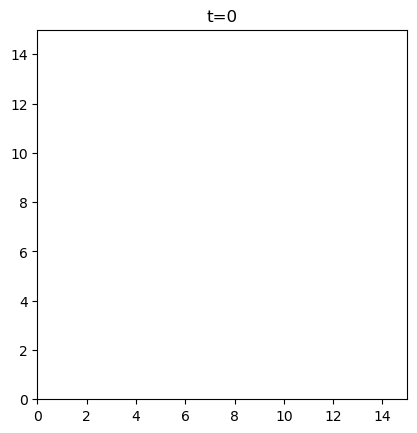

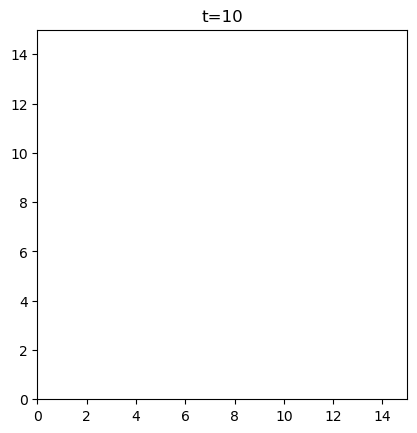

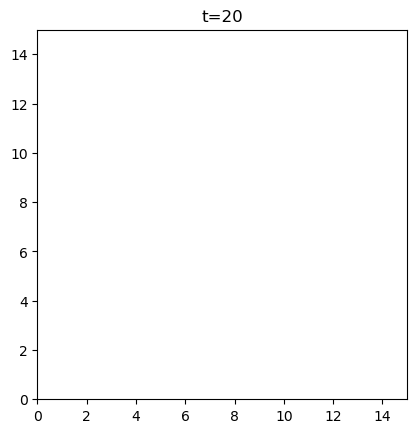

In [26]:
for i in range(0,steps,10):
    graphC(allstreams[i],i,5)